In [174]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

from scipy import ndimage

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

from wofs import filters

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
#define area of interest
query = {
    
        #Tanbar QLD
# 'y': (-26.141, -26.269),
# 'x': (141.482, 141.669), 
   
        #Tuross Head
# 'y': (-36.01, -36.092),
# 'x': (150.047, 150.186), 
    
    #Pambula wetlands
'y': (-36.924, -36.988),
'x': (149.848, 149.925), 
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
#     #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
    #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
# 'y': (-35.270, -35.336),
# 'x': (149.021, 149.194),    

#ACT LArge
# 'y': (-35.216, -35.414),
# 'x': (149.040, 149.309),      
    
    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
    
    
'time': ('2018-06-01', '2018-08-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [176]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8

<xarray.Dataset>
Dimensions:          (time: 11, x: 313, y: 320)
Coordinates:
  * time             (time) datetime64[ns] 2018-06-03T23:49:28 ... 2018-08-22T23:50:11
  * y                (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x                (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 4904 -999 -999 -999 ... 690 691 707 720
    blue             (time, y, x) int16 4762 -999 -999 -999 ... 504 503 515 510
    green            (time, y, x) int16 5041 -999 -999 -999 ... 350 351 350 354
    red              (time, y, x) int16 5272 -999 -999 -999 ... 213 215 217 214
    nir              (time, y, x) int16 6373 -999 -999 -999 ... 130 131 136 139
    swir1            (time, y, x) int16 5176 -999 -999 -999 8546 ... 35 34 36 34
    swir2            (time, y, x) int16 4200 -999 -999 -999 6869 ... 20 21 20 23
Attributes:
    crs:      EPSG: 3577

In [177]:
query2 = { 
   
'y': (-36.924, -36.988),
'x': (149.848, 149.925),  
    
# 'time': ('2018-01-01', '2018-03-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}

In [178]:
dsm = dc.load(product='dsm1sv10',**query2)
dsm = dsm.isel(time=0)
dsm

<xarray.Dataset>
Dimensions:    (x: 313, y: 320)
Coordinates:
    time       datetime64[ns] 2000-02-17T08:33:00
  * y          (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x          (x) float64 1.589e+06 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    elevation  (y, x) float32 111.40662 109.43131 119.75318 ... 0.0 0.0 0.0
Attributes:
    crs:      EPSG: 3577

In [179]:
#define number of total observations

total_obs = int(len(data_lst8.time))
total_obs

11

In [180]:
#turn terrain masked values form -999 to Nan

want_to_mask = (data_lst8 == -999).to_array(dim='variables').all(dim='variables')
terrain_out = data_lst8.copy(deep=True).where(~want_to_mask, np.NaN)

In [181]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 11, x: 313, y: 320)
Coordinates:
  * time          (time) datetime64[ns] 2018-06-03T23:49:28 ... 2018-08-22T23:50:11
  * y             (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x             (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    pixelquality  (time, y, x) int16 13311 13311 13311 ... 15871 15871 15871
Attributes:
    crs:      EPSG: 3577

In [182]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 11, y: 320, x: 313)>
array([[[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ...,  True,  True],
        [False, False, ...,  True,  True]],

       [[ True, False, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       ...,

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-06-03T23:49:28 ... 2018-08-22T23:50:11
  * y        (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x        

In [183]:
#apply Mask
Masked_lst8_data = terrain_out.where(good_quality)

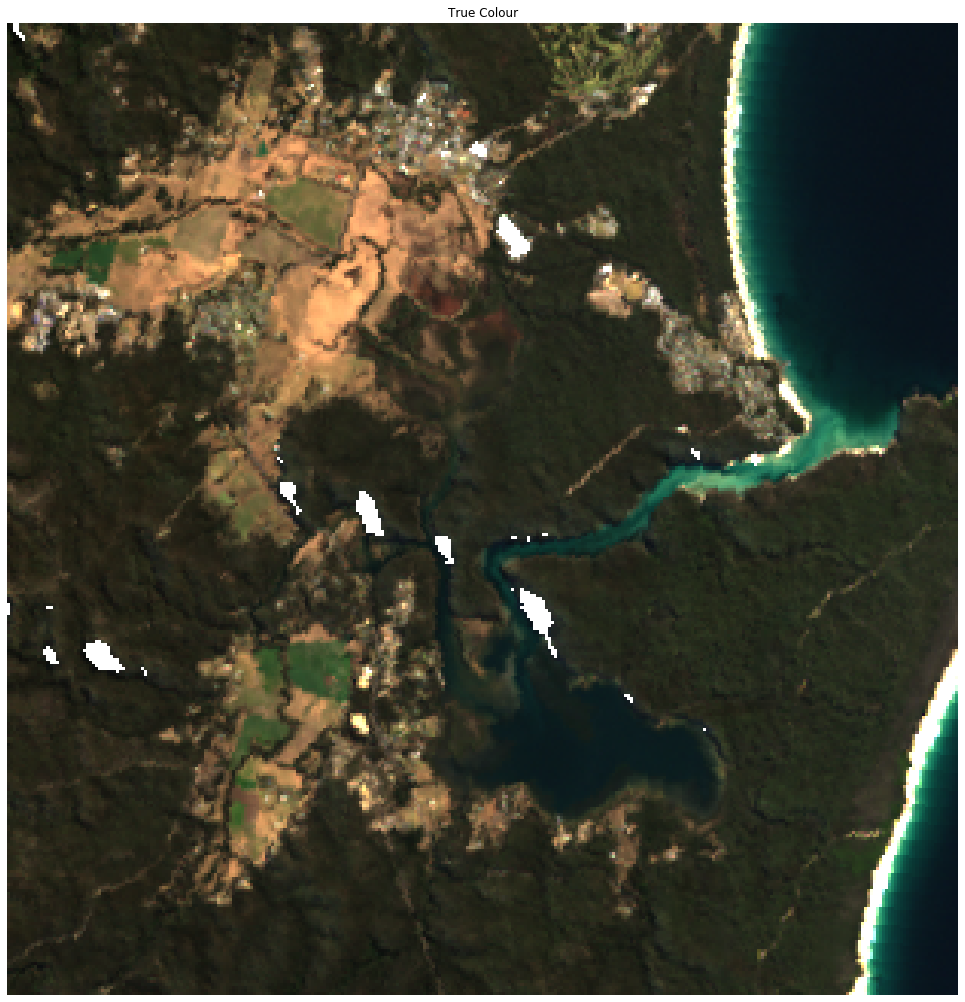

In [184]:
tx = 7

data_lst8_once = Masked_lst8_data.isel(time=tx)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [185]:
terrain_mask = filters.terrain_filter(dsm,data_lst8.isel(time=tx))

In [213]:
goodpixels = (mywofsdata & np.uint8(0b01111011)) == 0

123

In [186]:
terrain_mask2 = terrain_mask.where(terrain_mask>10,0)
buff_terrain = xr.DataArray(ndimage.binary_dilation(terrain_mask2, iterations=2).astype(terrain_mask2.dtype),dims=('y', 'x'))
terrain_mask['buff'] = buff_terrain

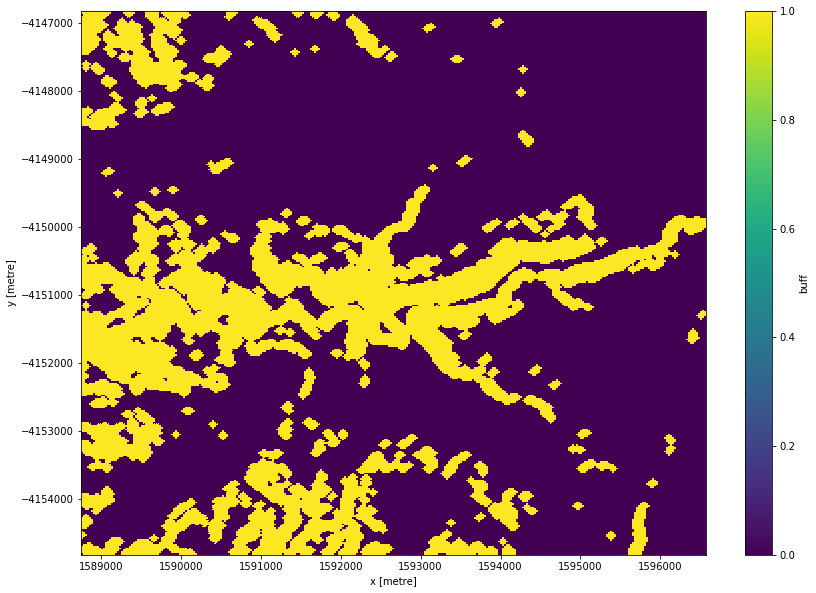

In [187]:
terrain_mask.buff.plot(figsize =(14,10))

In [188]:
#Do tassled Cap transformation
TCI = TasseledCapTools.thresholded_tasseled_cap(Masked_lst8_data,wetness_threshold=-1200, drop=True
                                                , drop_tc_bands=False)
tcw = TCI['wetness']




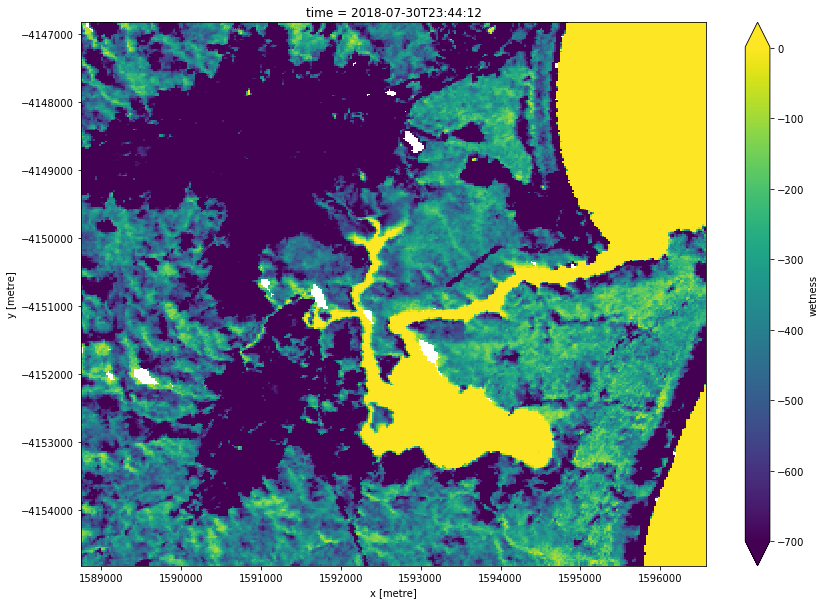

In [205]:
tcw.isel(time=tx).plot(cmap='viridis', figsize =(14,10),vmin=-700, vmax=1)

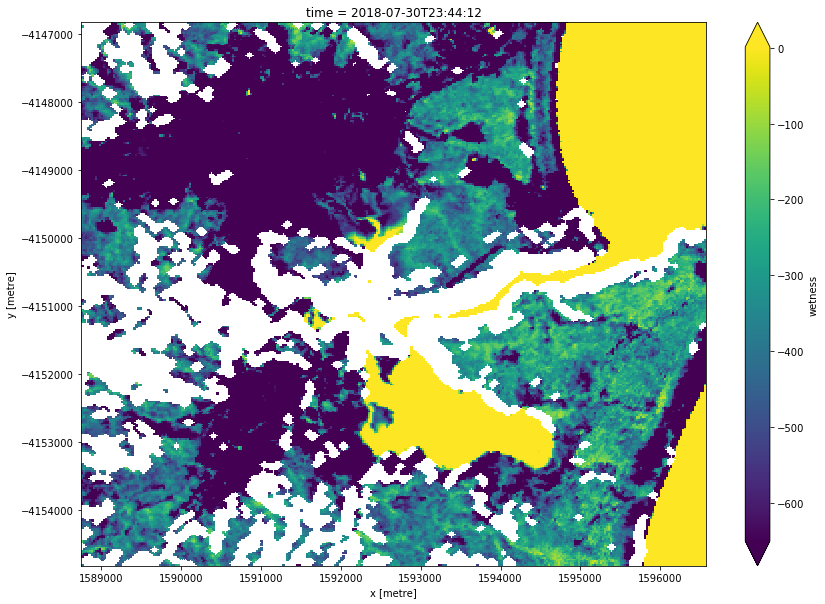

In [206]:
tcw_masked_T = tcw.isel(time=tx).where(terrain_mask.buff<1)
tcw_masked_T.plot(figsize =(14,10),vmin=-650, vmax=1)

In [191]:
#make Fisher index

lst_fisher = 1.7204 +((171*Masked_lst8_data['green'])+(3*Masked_lst8_data['red'])-(70*Masked_lst8_data['nir'])-(45*Masked_lst8_data['swir1'])-(71*Masked_lst8_data['swir2']))/10000
lst_fisher

<xarray.DataArray (time: 11, y: 320, x: 313)>
array([[[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,   0.7935,   0.3382],
        [     nan,      nan, ...,   0.8366,   0.7297]],

       [[-11.7096,      nan, ...,   4.0878,   4.1064],
        [-10.285 ,      nan, ...,   4.1123,   4.2068],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[ -8.0518, -11.8975, ...,   3.2652,   3.3231],
        [-11.2575, -11.5227, ...,   3.2517,   3.3508],
        ...,
        [-17.3181, -16.3007, ...,   3.401 ,   3.4803],
        [-17.3688, -17.224 , ...,   3.3326,   3.3818]],

       [[ -4.5383,  -8.3369, ...,   6.4216,   6.2935],
        [ -6.0785,  -6.7367, ...,   6.3194,   6.3827],
        ...,
        [-12.0245, -10.6385, ...,   6.5114,   6.5734],
        [-13.5877, -12.446 , ...,   6.5145,   6.5487]]])
C

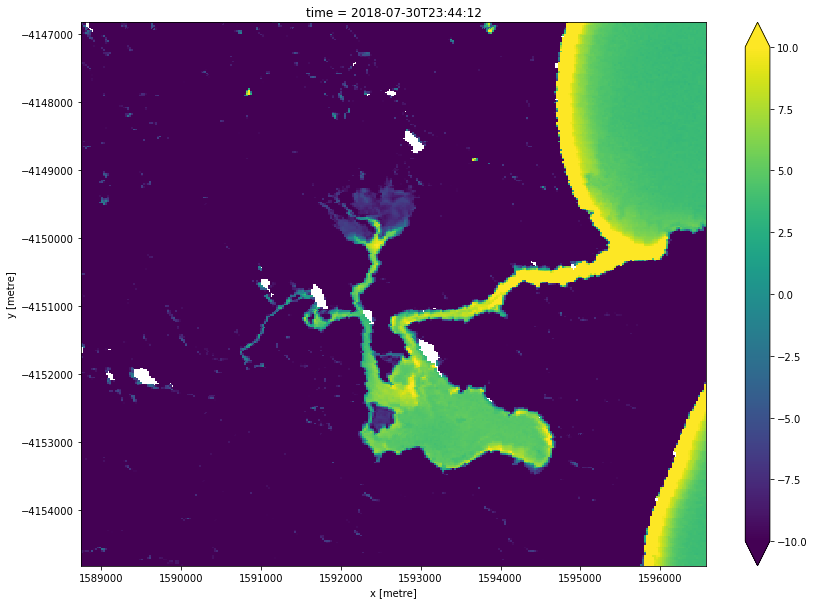

In [192]:
lst_fisher.isel(time=tx).plot(cmap='viridis', figsize =(14,10),vmin=-10,)

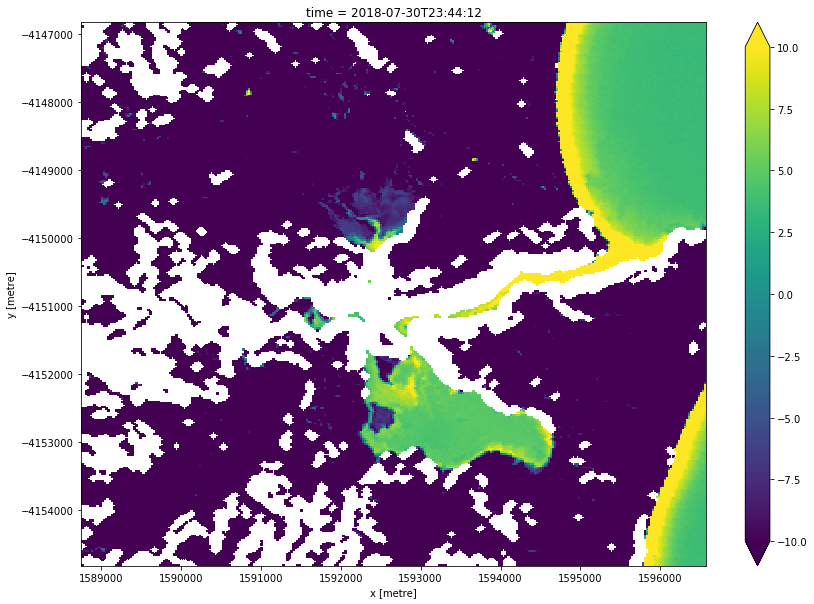

In [193]:
fisher_masked_T = lst_fisher.isel(time=tx).where(terrain_mask.buff<1)
fisher_masked_T.plot(cmap='viridis',figsize =(14,10),vmin=-10)

In [207]:
inundated_veg_msk = (np.logical_and(lst_fisher>=-10,tcw>=-650))
inundated_veg = lst_fisher.where(inundated_veg_msk==True,0)
inundated_veg = inundated_veg.where(inundated_veg_msk==False,1)

In [208]:
inundated_veg_msk2 = (np.logical_and(fisher_masked_T>=-10,tcw_masked_T>=-650))
inundated_veg_terrain = fisher_masked_T.where(inundated_veg_msk2==True,0)
inundated_veg_terrain = inundated_veg_terrain.where(inundated_veg_msk2==False,1)

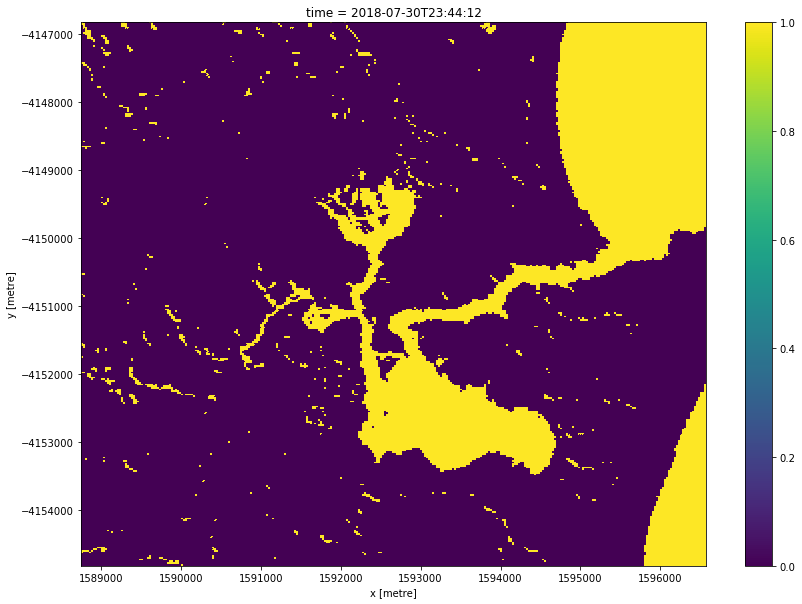

In [209]:
inundated_veg.isel(time=tx).plot(cmap='viridis', figsize =(14,10))

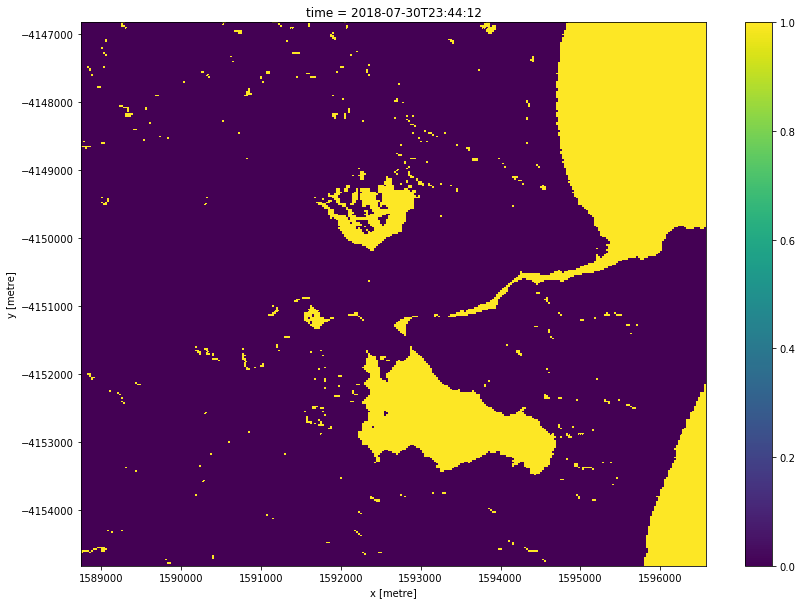

In [210]:
inundated_veg_terrain.plot(cmap='viridis',figsize =(14,10))

wet_frequency = inundated_veg.sum(dim='time')

wet_frequency.plot(cmap='viridis', figsize =(14,10))

precent_threhold = total_obs*0.1
precent_threhold

persistant_wet = wet_frequency.where(wet_frequency>precent_threhold,0)

persistant_wet.plot(figsize =(15,12))

In [198]:
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
#write_geotiff('/g/data/u46/users/ck9738/Datasets/Tasselled_cap_tifs/Tuross_heads_tassel_wi_fisher_2018_stacked.tif',Data_out_once)